## Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [15]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2


# *****************************************************
## Import And Preprocess Data Set

In [6]:
df = pd.read_csv("/content/drive/My Drive/climate5April/GlobalTemp.csv",skiprows=4)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert Effective date type to datetime
df['Date'] = pd.to_datetime(df['Date'].astype(str).str[:4] + '-' + df['Date'].astype(str).str[4:], format='%Y-%m')

# Remove timezone from effective date column
# df['DATE'] = pd.to_datetime(df['DATE']).dt.tz_localize(None)
df.head(2)

,Date,Anomaly
0,1850-01-01,-0.46
1,1850-02-01,-0.22


In [7]:
df=df.loc[df['Date']>='2000-01-01']

In [8]:
df.set_index('Date', inplace=True)

df.head()

,Anomaly
Date,
2000-01-01,0.32
2000-02-01,0.55
2000-03-01,0.53
2000-04-01,0.60
2000-05-01,0.37


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2000-01-01 to 2024-05-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Anomaly  293 non-null    float64
dtypes: float64(1)
memory usage: 4.6 KB


In [10]:
train = df[:190]
valid = df[190:250]
test = df[250:]

scaler = MinMaxScaler()

# Fit scaler on training data and transform all subsets
train_data = scaler.fit_transform(train[['Anomaly']])
validate_data = scaler.transform(valid[['Anomaly']])
test_data = scaler.transform(test[['Anomaly']])

print("Train data size:", len(train_data))
print("Validation data size:", len(validate_data))
print("Test data size:", len(test_data))



Train data size: 190
Validation data size: 60
Test data size: 43


In [11]:
from keras.layers import Bidirectional
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 1 # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_val,y_val=create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [16]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM, Dropout, Concatenate

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5# Number of time steps to look back (increase for CNN effect)
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape for CNN and LSTM
X_train_cnn = X_train.reshape(-1, seq_length, 1)
X_val_cnn = X_val.reshape(-1, seq_length, 1)
X_test_cnn = X_test.reshape(-1, seq_length, 1)

X_train_lstm = X_train.reshape(-1, seq_length, 1)
X_val_lstm = X_val.reshape(-1, seq_length, 1)
X_test_lstm = X_test.reshape(-1, seq_length, 1)

# Input shape for CNN
cnn_input = Input(shape=(seq_length, 1))
x = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)  # Using a larger kernel size
x = MaxPooling1D(pool_size=2)(x)  # Adjust pooling to reduce dimensionality
x = Flatten()(x)

# LSTM Model
lstm_input = Input(shape=(seq_length, 1))
y = Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(0.01)))(lstm_input)
y = Dropout(0.5)(y)
y = Bidirectional(LSTM(200))(y)
y = Dropout(0.5)(y)
y = Dense(100, activation='relu')(y)

combined = Concatenate()([x, y])
combined = Dense(100, activation='relu')(combined)
combined = Dense(1)(combined)

model = Model(inputs=[cnn_input, lstm_input], outputs=combined)

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

history = model.fit([X_train_cnn, X_train_lstm], y_train, epochs=100, batch_size=32, validation_data=([X_val_cnn, X_val_lstm], y_val))

loss = model.evaluate([X_test_cnn, X_test_lstm], y_test)
print(f'Test Loss: {loss}')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 5, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 5, 400)         │        323,200 │ input_layer_5[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 5, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 5, 400)         │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 3, 64)          │            256 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 400)            │        961,600 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 1, 64)          │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 400)            │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 64)             │              0 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 100)            │         40,100 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 164)            │              0 │ flatten_2[0][0],       │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 100)            │         16,500 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            101 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,341,757 (5.12 MB)

 Trainable params: 1,341,757 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - loss: 0.1964 - val_loss: 0.0978
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0653 - val_loss: 0.0966
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0511 - val_loss: 0.0563
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0387 - val_loss: 0.0406
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0365 - val_loss: 0.0554
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0330 - val_loss: 0.0415
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0290 - val_loss: 0.0337
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0260 - val_loss: 0.0446
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0236 - val_loss: 0.0345
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0228 - val_loss: 0.0306
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0224 - val_loss: 0.0335
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0190 - val_l

In [17]:
import numpy as np
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [18]:
model.save('hybrid2.h5')


In [ ]:
model.save('lstm.h5')


In [19]:

X_train_cnn = X_train.reshape(-1, seq_length, 1)
X_val_cnn = X_val.reshape(-1, seq_length, 1)

# Reshape for LSTM input (1D LSTM expects 3D input)
X_train_lstm = X_train.reshape(-1, seq_length, 1)
X_val_lstm = X_val.reshape(-1, seq_length, 1)

# Make predictions
train_predict = model.predict([X_train_cnn, X_train_lstm])
val_predict = model.predict([X_val_cnn, X_val_lstm])

train_predict = train_predict.reshape(-1)
val_predict = val_predict.reshape(-1)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

test_predictions = model.predict([X_test_cnn, X_test_lstm])
test_predictions = scaler.inverse_transform(test_predictions)

train_mse = mean_squared_error(y_train, train_predict)
val_mse = mean_squared_error(y_val, val_predict)
test_mse = mean_squared_error(y_test, test_predictions)

train_rmse = sqrt(train_mse)
val_rmse = sqrt(val_mse)
test_rmse = sqrt(test_mse)

train_mae = mean_absolute_error(y_train, train_predict)
val_mae = mean_absolute_error(y_val, val_predict)
test_mae = mean_absolute_error(y_test, test_predictions)

train_r2 = r2_score(y_train, train_predict)
val_r2 = r2_score(y_val, val_predict)
test_r2 = r2_score(y_test, test_predictions)

print(f"Train MSE: {train_mse:.4f}")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}\n")

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}\n")

print(f"Train MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}\n")

print(f"Train R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Train MSE: 0.0114
Validation MSE: 0.0153
Test MSE: 0.0223

Train RMSE: 0.1069
Validation RMSE: 0.1238
Test RMSE: 0.1493

Train MAE: 0.0861
Validation MAE: 0.0943
Test MAE: 0.1259

Train R²: 0.5742
Validation R²: 0.1063
Test R²: 0.6711


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


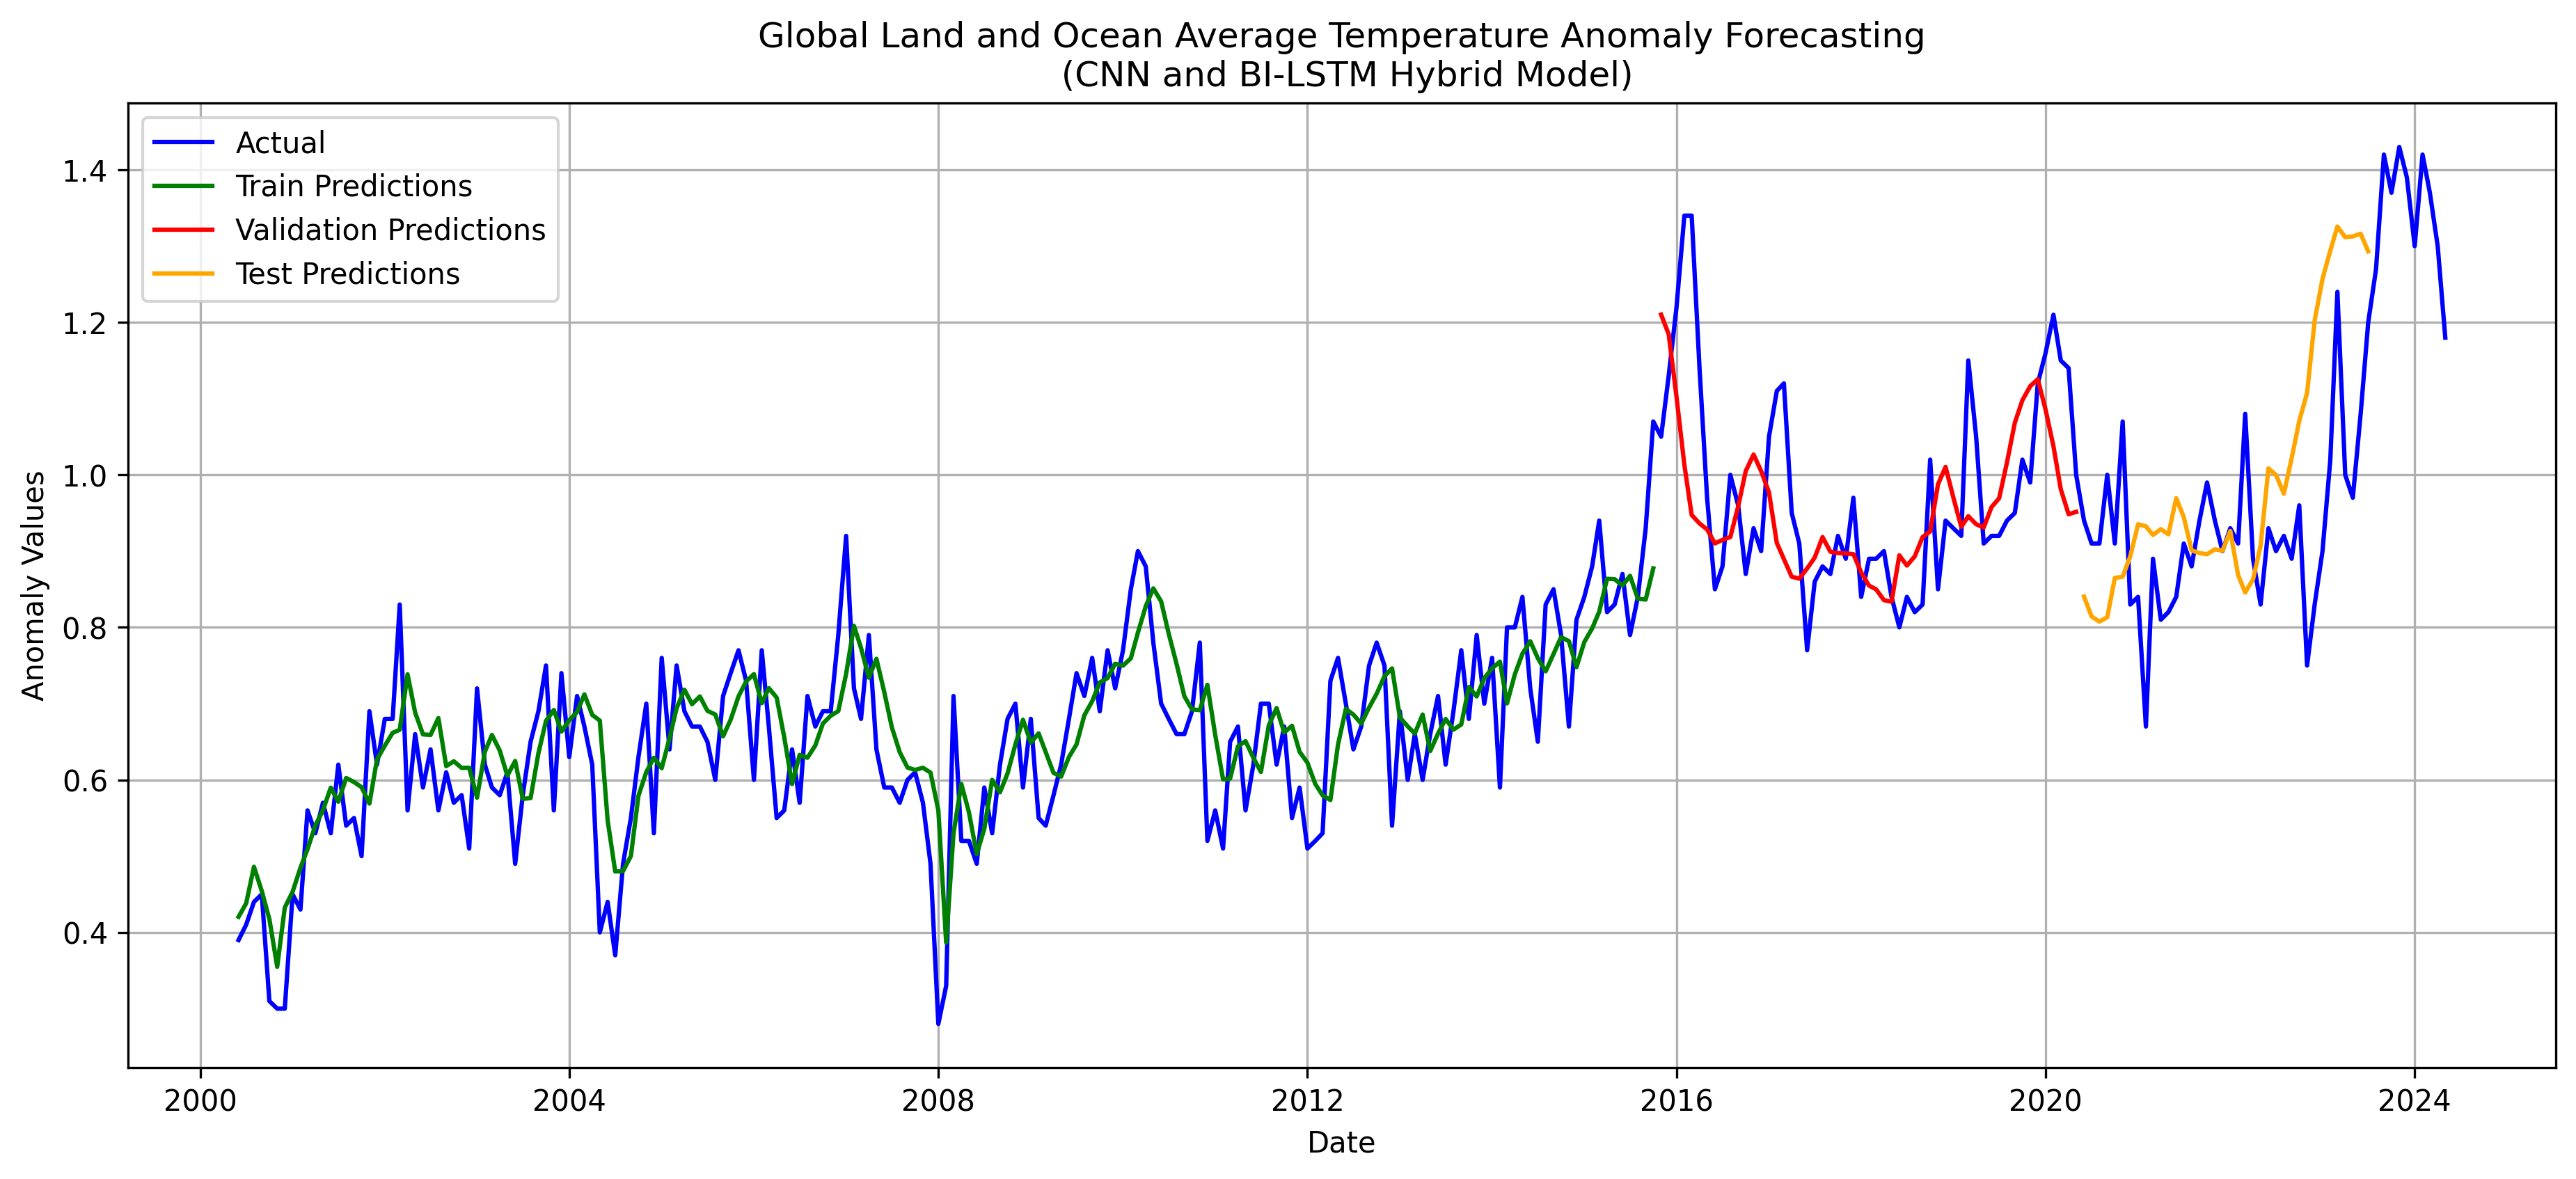

In [21]:
import matplotlib.pyplot as plt

# Make predictions
train_predictions = model.predict([X_train_cnn, X_train_lstm])
val_predictions = model.predict([X_val_cnn, X_val_lstm])
test_predictions = model.predict([X_test_cnn, X_test_lstm])

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
val_predictions = scaler.inverse_transform(val_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Create a figure for plotting
plt.figure(figsize=(15, 6),dpi=300)

# Plot actual values
plt.plot(df.index[seq_length:], df['Anomaly'][seq_length:], label='Actual', color='blue')

# Plot training predictions
plt.plot(df.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions', color='green')

# Plot validation predictions
val_pred_index = range(seq_length + len(train_predictions), seq_length + len(train_predictions) + len(val_predictions))
plt.plot(df.index[val_pred_index], val_predictions, label='Validation Predictions', color='red')

# Plot test predictions
test_pred_index = range(seq_length + len(train_predictions) + len(val_predictions),
                        seq_length + len(train_predictions) + len(val_predictions) + len(test_predictions))
plt.plot(df.index[test_pred_index], test_predictions, label='Test Predictions', color='orange')

# Configure plot
plt.title('Global Land and Ocean Average Temperature Anomaly Forecasting\n (CNN and BI-LSTM Hybrid Model)')
plt.xlabel('Date')
plt.ylabel('Anomaly Values')
plt.legend()
plt.grid()  # Optional


In [22]:
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM, Dropout


In [23]:
model = Sequential()
model.add(Bidirectional(LSTM(200, return_sequences=True), input_shape=(seq_length, 1)))
model.add(Dropout(0.2))  # Add dropout layer to prevent overfitting
model.add(Bidirectional(LSTM(200)))
model.add(Dropout(0.2))  # Add another dropout layer
model.add(Dense(100, activation='relu'))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.1452 - val_loss: 0.1174
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0379 - val_loss: 0.0987
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0270 - val_loss: 0.0207
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0229 - val_loss: 0.0258
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0141 - val_loss: 0.0299
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0151 - val_loss: 0.0187
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0149 - val_loss: 0.0279
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0151 - val_loss: 0.0206
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0141 - val_loss: 0.0232
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0156 - val_loss: 0.0199
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0128 - val_loss: 0.0213
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0150 - val_l

In [24]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_val)
test_predict1 = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [28]:
# Inverse transform the predictions and actual values
train_predict_L = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict_L = scaler.inverse_transform(test_predict)

test_predictL1 = scaler.inverse_transform(test_predict1)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# MSE
train_mse = mean_squared_error(y_train, train_predict_L)
test_mse = mean_squared_error(y_test, test_predictL1)
val_mse = mean_squared_error(y_val, test_predict_L)

# RMSE
train_rmse = sqrt(train_mse)
test_rmse = sqrt(test_mse)
val_rmse = sqrt(val_mse)

# MAE
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict1)
val_mae = mean_absolute_error(y_val, val_predict)

# R²
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict1)
val_r2 = r2_score(y_val, val_predict)

# Output
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Validation MSE: {val_mse}')
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Validation RMSE: {val_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')
print(f'Validation MAE: {val_mae}')
print(f'Train R²: {train_r2}')
print(f'Test R²: {test_r2}')
print(f'Validation R²: {val_r2}')


Train MSE: 0.004993907474388343
Test MSE: 0.007686873946664527
Validation MSE: 0.00527660074538496
Train RMSE: 0.07066758432540583
Test RMSE: 0.08767481934206951
Validation RMSE: 0.07264021438146338
Train MAE: 0.13262626289161486
Test MAE: 0.11532631930552042
Validation MAE: 0.1818320506841488
Train R²: -1.112436602402012
Test R²: 0.2880963084799636
Validation R²: -5.07114840751111


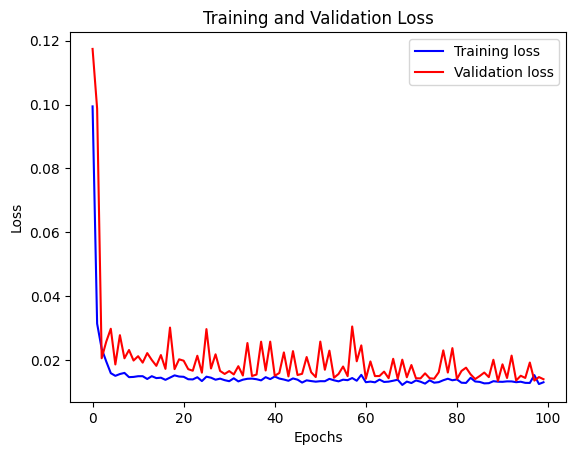

In [30]:
import matplotlib.pyplot as plt

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]  # Retrieve validation loss
    epochs = range(len(loss))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")  # Plot validation loss with red color

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")



2/2 [==============================] - 0s 12ms/step


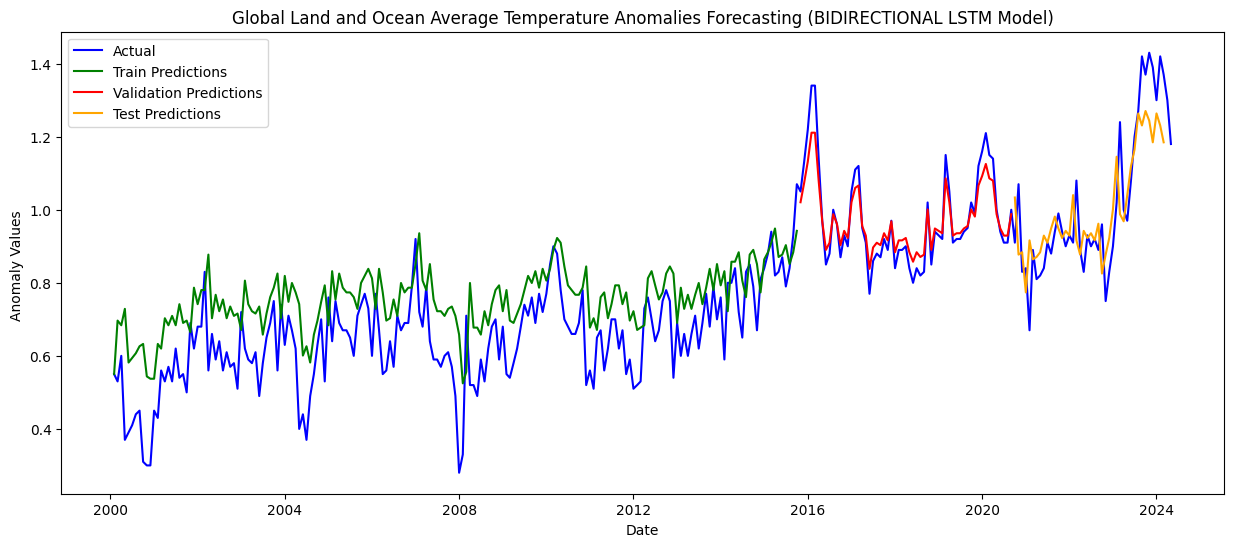

In [ ]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
val_predictions = model.predict(X_val)

train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
val_predictions = scaler.inverse_transform(val_predictions)


plt.figure(figsize=(15, 6))

plt.plot(df.index[seq_length:], df['Anomaly'][seq_length:], label='Actual', color='blue')

plt.plot(df.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions',color='green')


val_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(val_predictions))
plt.plot(df.index[val_pred_index], val_predictions, label='Validation Predictions', color='red')

test_pred_index = range(seq_length+len(train_predictions)+len(val_predictions), seq_length+len(train_predictions)+len(val_predictions)+len(test_predictions))
plt.plot(df.index[test_pred_index], test_predictions, label='Test Predictions', color='orange')

plt.title('Global Land and Ocean Average Temperature Anomalies Forecasting (BIDIRECTIONAL LSTM Model)')
plt.xlabel('Date')
plt.ylabel('Anomaly Values ')
plt.legend()
plt.show()